# Analyse des données ship segmentation Airbus

## Import

In [1]:
import pandas as pd
import numpy as np

from skimage.data import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

## Import fonctions additionnels

In [2]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

## Chargement des données

In [3]:
#data_dir = 'C:/Users/Thibault/Documents/Cours/ParisTech_offline/ProjetFilRouge_Airbus - INFMDI780/Dataset/'
# data_dir = 'Dataset/'
data_dir = 'C:/Users/Thibault/Documents/Data/airbus-ship-detection/'
print(os.listdir(data_dir))

['sample_submission_v2.csv', 'Test', 'Train', 'train_ship_segmentations_v2.csv']


In [10]:
train_subDir = 'Train/'
test_subDir = 'Test/'

### Nombre d'échantillion

In [11]:
train = os.listdir(data_dir + train_subDir)
print("Length of train set :", len(train))

test = os.listdir(data_dir + test_subDir)
print("Length of test set :  ", len(test))

Length of train set : 192560
Length of test set :   15606


### Format des labels

In [12]:
label = pd.read_csv(data_dir + 'train_ship_segmentations_v2.csv')
label.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


## Etude du nombre d'échantillon par nombre de bateau pour chaque échantillion

### Nombre d'échantillon avec au moins un bateau sur l'image

In [13]:
label_WithShip = label[label['EncodedPixels'].notnull()]
label_WithShip_noDup = label[label['EncodedPixels'].notnull()].drop_duplicates(subset = 'ImageId')

label_WithnoShip = label[label['EncodedPixels'].isnull()]
count_data_WithShip = len(label_WithShip_noDup)
count_data_WithnoShip = len(label_WithnoShip)

print("Count images with ship", count_data_WithShip)
print("Count images without ship", count_data_WithnoShip)
print("Pourcentage d'images avec au moins un bateau : {:.2f} %".format(count_data_WithShip/len(label)*100))

Count images with ship 42556
Count images without ship 150000
Pourcentage d'images avec au moins un bateau : 18.37 %


In [14]:
df_analysis = label
df_analysis['ship_count'] = df_analysis.groupby('ImageId')['ImageId'].transform('count')
df_analysis.loc[df_analysis['EncodedPixels'].isnull().values,'ship_count'] = 0  #see infocusp's comment
print(df_analysis['ship_count'].describe())

count    231723.000000
mean          1.344472
std           2.755929
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64


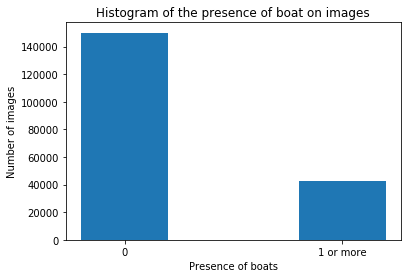

In [15]:
hist_images_boat = np.unique(np.array(label.drop_duplicates(subset = 'ImageId')['EncodedPixels'].notnull()).astype(int), return_counts=True)
plt.bar(hist_images_boat[0], hist_images_boat[1], width=0.4, tick_label=['0', '1 or more'])
plt.title('Histogram of the presence of boat on images')
plt.xlabel('Presence of boats')
plt.ylabel('Number of images')
plt.show()

### Nombre d'échantillon sur le nombre de bateau par échantillon avec au moins un bateaux

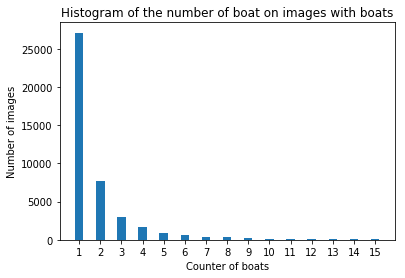

In [16]:
label_countBoat = label_WithShip['ImageId'].value_counts()
hist_images_count_boat = np.unique(label_countBoat, return_counts=True)
plt.bar(hist_images_count_boat[0], hist_images_count_boat[1], width=0.4, tick_label=hist_images_count_boat[0])
plt.title('Histogram of the number of boat on images with boats')
plt.xlabel('Counter of boats')
plt.ylabel('Number of images')
plt.show()

### Exemple d'un résultat pour une image avec 5 bateaux

In [17]:
id_image_with5boat = label_countBoat[label_countBoat == 5].index[0]
df_image_with5boat_Dup = label.where(label['ImageId'] == id_image_with5boat).dropna()
df_image_with5boat_Dup

,ImageId,EncodedPixels,ship_count
219072,f20f27c4a.jpg,192089 2 192857 4 193624 5 194392 4 195159 5 1...,5.0
219073,f20f27c4a.jpg,288077 1 288844 3 289611 5 290378 7 291145 9 2...,5.0
219074,f20f27c4a.jpg,228430 1 229197 3 229964 5 230731 8 231499 9 2...,5.0
219075,f20f27c4a.jpg,287611 1 288378 3 289145 5 289912 7 290679 9 2...,5.0
219076,f20f27c4a.jpg,433594 4 434362 10 435130 13 435897 14 436665 ...,5.0


## Etude des observation (X) par rapport au label (y)

### Prenons le cas pour la premier image avec un ou plusieurs bateaux

In [18]:
enc_mask1 = label_WithShip_noDup.iloc[0]['EncodedPixels']
id_image1 = label_WithShip_noDup.iloc[0]['ImageId']

In [19]:
mask1 = rle_decode(enc_mask1)
print("Image id :", id_image1)
img1_dir = data_dir + train_subDir + id_image1
print("Image dir :", img1_dir)
image1 = imread(img1_dir)

Image id : 000155de5.jpg
Image dir : C:/Users/Thibault/Documents/Data/airbus-ship-detection/Train/000155de5.jpg


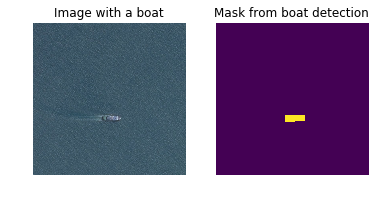

In [20]:
plt.subplot(121)
plt.imshow(image1)
plt.title('Image with a boat')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask1)
plt.title('Mask from boat detection')
plt.axis('off')

plt.show()

### Prenons le cas pour une image avec plusieurs bateaux

In [21]:
id_image_with5boat = label_countBoat[label_countBoat == 5].index[1]
df_image_with5boat_noDup = label_WithShip_noDup.where(label['ImageId'] == id_image_with5boat).dropna()

In [22]:
df_image_with5boat_Dup = label.where(label['ImageId'] == id_image_with5boat).dropna()
df_image_with5boat_Dup

,ImageId,EncodedPixels,ship_count
189902,d207a3b38.jpg,291982 6 292745 11 293513 11 294281 11 295049 ...,5.0
189903,d207a3b38.jpg,240864 3 241629 6 242397 6 243165 6 243933 6 2...,5.0
189904,d207a3b38.jpg,176356 3 177121 6 177889 6 178657 6 179425 6 1...,5.0
189905,d207a3b38.jpg,305031 4 305795 8 306563 8 307331 8 308099 8 3...,5.0
189906,d207a3b38.jpg,11474 9 12242 18 13010 18 13778 18 14546 18 15...,5.0


In [23]:
masks = []
for enc_mask in df_image_with5boat_Dup['EncodedPixels']:
    masks.append(rle_decode(enc_mask))
    
id_image = id_image_with5boat
print("Image id :", id_image)
img_dir = data_dir + train_subDir + id_image
print("Image dir :", img_dir)
image = imread(img_dir)

Image id : d207a3b38.jpg
Image dir : C:/Users/Thibault/Documents/Data/airbus-ship-detection/Train/d207a3b38.jpg


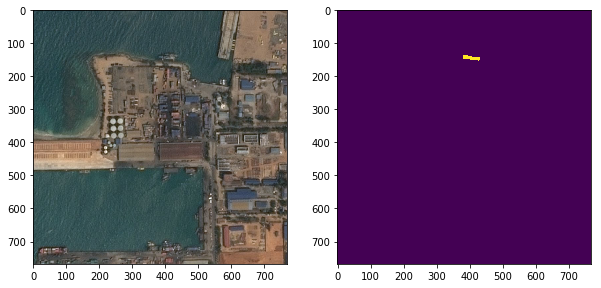

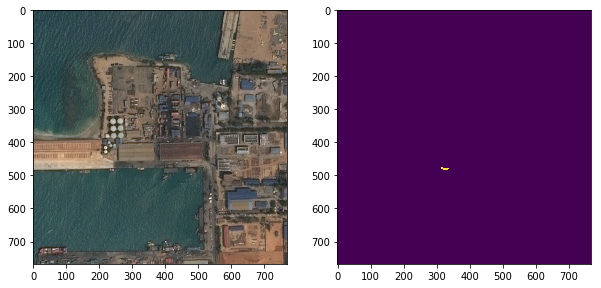

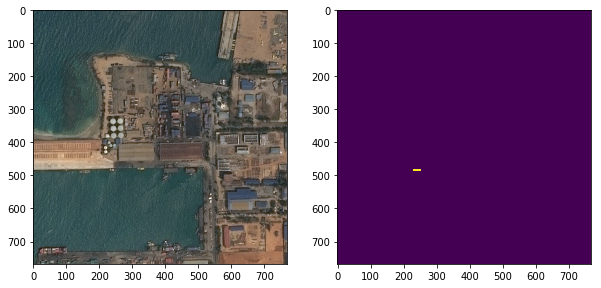

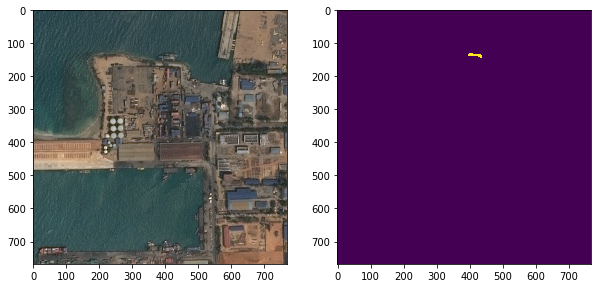

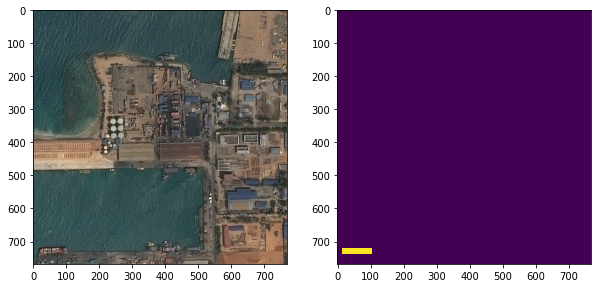

In [24]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

## Create smaller dataset

In [25]:
if False:
    new_dir = "New_Dataset/train/"
    #save data with ship
    for id in data_WithShip.iloc[:50]['ImageId']:
        actual_dir_image = data_dir + train_subDir + id
        print(actual_dir_image)
        image = plt.imread(actual_dir_image)
        new_dir_image =  new_dir + id
        plt.imsave(new_dir_image, image)

    #save data with ship
    for id in data_WithnoShip.iloc[:50]['ImageId']:
        actual_dir_image = data_dir + train_subDir +id
        image = plt.imread(actual_dir_image)
        new_dir_image =  new_dir + id
        plt.imsave(new_dir_image, image)

## Etude de la taille des bateaux

In [26]:
list_enc_mask = list(df_analysis['EncodedPixels'])
list_length = []
for enc_mask in list_enc_mask:
    length = 0
    if isinstance(enc_mask, str):
        for x in enc_mask.split(" ")[1:][::2]:
            length += int(x)
    list_length.append(length)
df_analysis['SizeBoat'] = list_length
df_analysis

,ImageId,EncodedPixels,ship_count,SizeBoat
0,00003e153.jpg,NaN,0,0
1,0001124c7.jpg,NaN,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,3388
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5,177
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5,148
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5,480
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5,7
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,5,648
8,0001b1832.jpg,NaN,0,0
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9,400


In [27]:
df_analysis_sizeboat = df_analysis[df_analysis['ship_count']!=0]['SizeBoat']

In [28]:
bins = int(np.max(df_analysis_sizeboat)/10) 

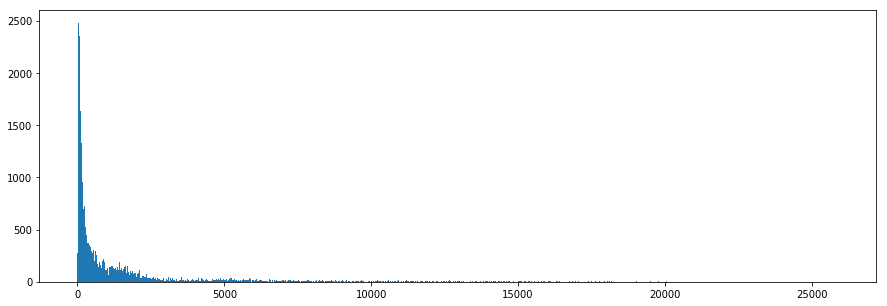

In [29]:
plt.figure(figsize=(15,5))
plt.hist(df_analysis_sizeboat, bins=bins)
plt.show()

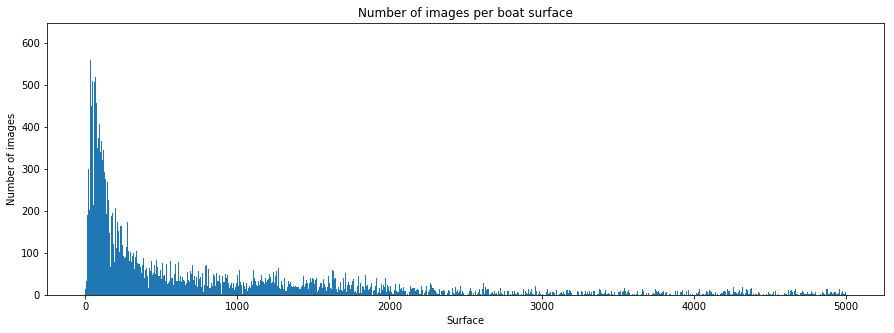

In [30]:
plt.figure(figsize=(15,5))
plt.hist(df_analysis_sizeboat, bins=bins, range=(0, 5000))
plt.title('Number of images per boat surface')
plt.xlabel('Surface')
plt.ylabel('Number of images')
plt.show()

In [37]:
df_analysis_perc = (df_analysis[df_analysis['ship_count']!=0]['SizeBoat']/(760*760))

In [38]:
df_analysis_perc.describe()

count    81723.000000
mean         0.002714
std          0.004921
min          0.000003
25%          0.000192
50%          0.000706
75%          0.002684
max          0.044848
Name: SizeBoat, dtype: float64

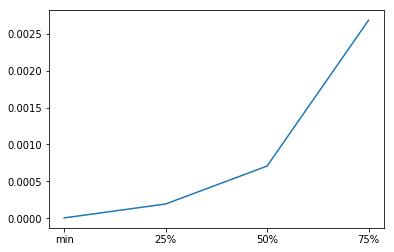

In [39]:
plt.plot(df_analysis_perc.describe()[3:7])

In [40]:
surface_mean_boat = 760*760 * np.mean(df_analysis_perc)
760*760 - surface_mean_boat

576032.5971513528

In [44]:
760*760

577600

In [45]:
surface_mean_boat

1567.4028486472598

In [42]:
np.mean(df_analysis_perc)

0.002713647591148303

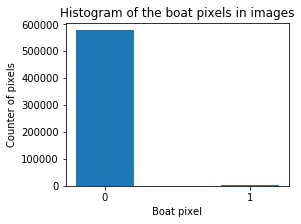

In [54]:
plt.figure(figsize=(4,3))
plt.bar([0,1], [576032 ,int(surface_mean_boat)], width=0.4, tick_label=[0,1])
plt.title('Histogram of the boat pixels in images')
plt.xlabel('Boat pixel')
plt.ylabel('Counter of pixels')
plt.show()